# Pretraining a Born Classifier

We'd like to extract as much performance form Born as possible, without complicating the model (we've seen that ensembling is not particularly effective anyhow, see the `born_ensemble.ipynb` notebook).

Pretraining seems like a natural way to go about it!

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import json

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt 
import seaborn as sns

import joblib

from bornrule import BornClassifier

from utils import get_dataframe_for_pretraining, encode_categorical

## Data preparation

In [2]:
datadir = "data"
df_in = pd.read_parquet(os.path.join(datadir, "pretrain.parquet"))

df_out = get_dataframe_for_pretraining(df_in, num_processes=5)

[+] Loading data from prepared.parquet.


In [3]:
df_out.sample(15)

,sentence_id,token,pos,dep,ner_tag
30657553,0,Gambia,PROPN,nmod,GPE
27180183,1,the,DET,det,NONE
25641210,1,eldest,ADJ,amod,NONE
29534202,0,",",PUNCT,punct,NONE
13688450,9,coenobia,PROPN,dobj,NONE
10232676,3,CD,NOUN,compound,NONE
2196526,0,Karlsson,PROPN,nsubj,PERSON
1601948,6,Inner,ADJ,amod,ORG
9857611,1,mi,NUM,appos,QUANTITY
72139,4,",",PUNCT,punct,NONE


In [4]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35824413 entries, 0 to 35824412
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   sentence_id  int64 
 1   token        object
 2   pos          object
 3   dep          object
 4   ner_tag      object
dtypes: int64(1), object(4)
memory usage: 1.3+ GB


In [5]:
df_out['ner_tag'].value_counts()

ner_tag
NONE           26635602
ORG             2460284
PERSON          1723805
DATE            1662194
GPE             1188244
CARDINAL         425493
NORP             370960
LOC              271220
WORK_OF_ART      215003
FAC              195547
QUANTITY         193367
EVENT            176207
ORDINAL          122088
PRODUCT           51924
TIME              30588
LAW               29359
MONEY             27780
PERCENT           23396
LANGUAGE          21352
Name: count, dtype: int64

## Data processing

We'll encode the categorical values more or less as in the CoNLL case, i.e., to ordinal ones instead of one-hot encoded ones.

In [6]:
cols_to_encode = set(df_out.columns) - {'sentence_id', 'token'}
encoded_df, encoder_mappings = encode_categorical(df_out, cols_to_encode)

In [7]:
encoded_df.sample(15)

,token,sentence_id,pos,dep,ner_tag
23592399,Urich,0,11,15,14
23952821,.,2,12,41,9
35009229,the,12,5,20,9
21777470,University,3,11,15,12
32802815,shorter,3,2,13,9
14224047,a,3,5,20,9
2987537,He,6,10,29,9
24340098,People,0,11,36,12
18137580,length,5,7,35,9
9185968,of,0,1,39,9


Now we proceed as we did in the CoNLL notebook.

In [8]:
X_train_valid, X_test = train_test_split(encoded_df, test_size=0.15)
X_train, X_valid = train_test_split(X_train_valid, test_size=0.3)

In [9]:
y_train = X_train.ner_tag.to_list()
X_train = X_train.drop('ner_tag', axis=1)

y_valid = X_valid.ner_tag.to_list()
X_valid = X_valid.drop('ner_tag', axis=1)

y_test = X_test.ner_tag.to_list()
X_test = X_test.drop('ner_tag', axis=1)

In [10]:
dict_vec = DictVectorizer()

X_train = dict_vec.fit_transform(X_train.to_dict('records'))
X_val = dict_vec.transform(X_valid.to_dict('records'))
X_test = dict_vec.transform(X_test.to_dict('records'))

## Training

In [11]:
born = BornClassifier()
# ~8s to train on ~36M tokens is quite impressive!
born.fit(X_train, y_train)

BornClassifier()

We need to save the model, the fitted `DictVectorizer` and the fitted encoder mappings: these three pieces work together!

In [12]:
os.makedirs("runs", exist_ok=True)

In [13]:
timestamp = datetime.now().strftime("%d%m%Y-%H%M%S")

clf_path = os.path.join("runs", f"clf_born_{timestamp}.joblib")
joblib.dump(born, clf_path)
print(f"[+] Classifier saved to {clf_path}.")

vec_path = os.path.join("runs", f"vec_clf_born_{timestamp}.joblib")
joblib.dump(dict_vec, vec_path)
print(f"[+] Vectoriser saved to {vec_path}")

enc_maps_path = os.path.join("runs", f"encmap_clf_born_{timestamp}.json")
with open(enc_maps_path, "w") as file:
    json.dump(encoder_mappings, file)
print(f"[+] Encoder mappings saved to {enc_maps_path}")

[+] Classifier saved to runs/clf_born_29082024-112112.joblib.
[+] Vectoriser saved to runs/vec_clf_born_29082024-112112.joblib
[+] Encoder mappings saved to runs/encmap_clf_born_29082024-112112.json


In [14]:
y_pred = born.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred, labels=np.unique(y_train)))

              precision    recall  f1-score   support

           0       0.44      0.30      0.36     63370
           1       0.92      0.39      0.55    249392
           2       0.37      0.52      0.43     26300
           3       0.31      0.19      0.24     29372
           4       0.75      0.49      0.59    178238
           5       0.52      0.90      0.66      3184
           6       0.01      0.26      0.02      4409
           7       0.11      0.48      0.18     40751
           8       0.02      0.64      0.04      4219
           9       0.98      0.46      0.63   3995615
          10       0.77      0.70      0.73     55693
          11       0.07      0.97      0.13     18226
          12       0.86      0.15      0.26    369248
          13       0.07      0.55      0.13      3482
          14       0.12      0.93      0.22    258086
          15       0.09      0.29      0.14      7876
          16       0.61      0.49      0.54     29084
          17       0.09    

A curious result.

Perhaps visualising the confusion matrix will tell us more!

In [15]:
labels = encoder_mappings['ner_tag']
cm = confusion_matrix(y_test, y_pred, labels=range(len(labels)), normalize='true')

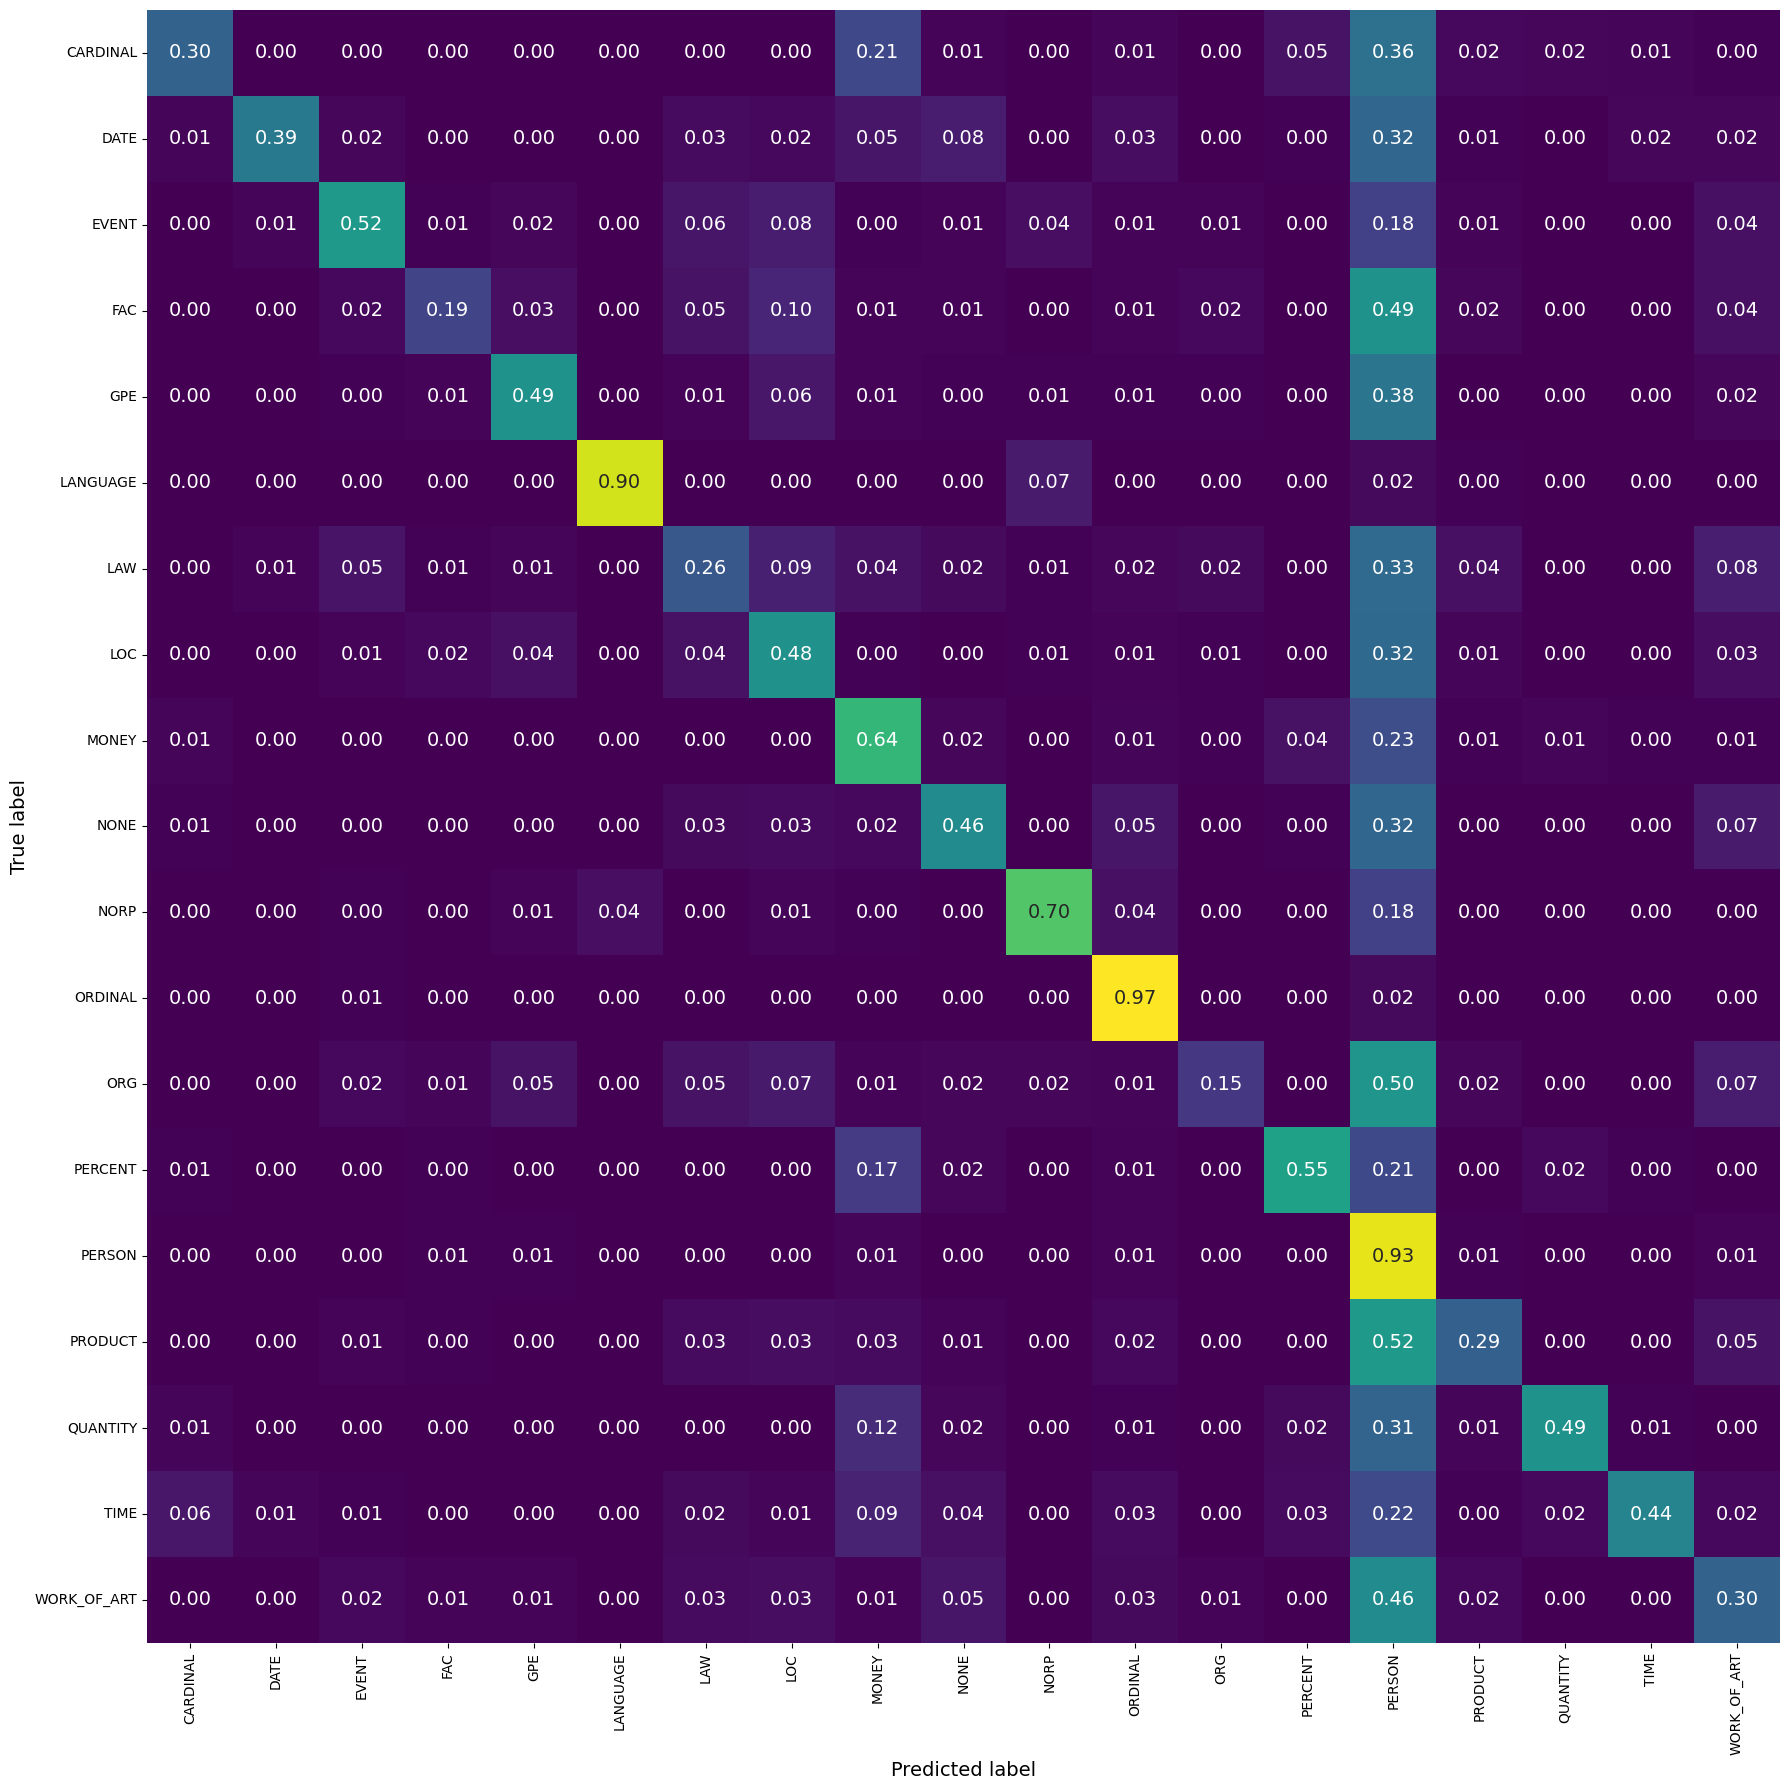

In [16]:
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(18, 18))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=labels, yticklabels=labels, 
            annot_kws={'size': 14}, cbar=False)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

plt.tight_layout()
plt.show()

This confusion matrix is actually quite a bit more heartening than the classification report: it's quite clear that the classifier has, in fact, learned something!

It's interesting to note that it seems to be the most confused about the `PERSON` tag.
Intuitively, this is not exceedingly surprising, especially when one looks at what person entities are most often confused with:
- `ORG`s (unsurprisingly, seeing as many organisations are named after people),
- `PRODUCT`s (for more or less the same reason as with organisations),
- `FAC`s (unsurprisingly, seeing as infrastructure is often named after people, e.g., the JFK Airport).

## Explanation 

In [17]:
features = dict_vec.get_feature_names_out()
columns = encoder_mappings['ner_tag']
explain_df = pd.DataFrame(born.explain().toarray(), index=features, columns=columns)

Let's use the same example as in the `born_on_conll.ipynb` notebook.

In [18]:
explain_df.loc['token=EU'].sort_values(ascending=False)

ORG            0.001578
EVENT          0.000775
GPE            0.000501
FAC            0.000387
PERSON         0.000282
NONE           0.000065
ORDINAL        0.000000
TIME           0.000000
QUANTITY       0.000000
PRODUCT        0.000000
PERCENT        0.000000
CARDINAL       0.000000
NORP           0.000000
DATE           0.000000
MONEY          0.000000
LOC            0.000000
LAW            0.000000
LANGUAGE       0.000000
WORK_OF_ART    0.000000
Name: token=EU, dtype: float64

In [19]:
explain_df['LANGUAGE'].sort_values(ascending=False).head(15)

token=English       0.227673
token=Arabic        0.051834
token=Hebrew        0.050953
token=Filipino      0.036001
token=Spanish       0.035917
token=French        0.033614
token=Latin         0.024033
token=Russian       0.014585
token=Chinese       0.013563
token=Mandarin      0.012915
token=German        0.012882
token=Portuguese    0.011645
token=Japanese      0.010265
token=Cantonese     0.009737
token=Polish        0.009174
Name: LANGUAGE, dtype: float64